<a href="https://colab.research.google.com/github/DevThiagoSc/Predicao_Valor_Imob/blob/main/Regressao_Imoveis_SP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDIÇÃO DE PREÇO DE IMÓVEIS NA CIDADE DE SÃO PAULO**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

In [2]:
df = pd.read_csv('base_imoveis_sp.csv', sep=';')

In [3]:
df.head()

,logradouro,numero,bairro,cep,cidade,tipo_imovel,area_util,banheiros,suites,quartos,vagas_garagem,anuncio_criado,tipo_anuncio,preco_venda,taxa_condominio,periodicidade,preco_aluguel,iptu_ano
0,Rua Juvenal Galeno,53,Jardim da Saúde,4290030.0,São Paulo,Casa de dois andares,388.0,3.0,1.0,4.0,6.0,07/02/2017,Venda,700000,NaN,NaN,NaN,NaN
1,Rua Juruaba,16,Vila Santa Teresa,4187320.0,São Paulo,Casa,129.0,2.0,1.0,3.0,2.0,21/03/2016,Venda,336000,NaN,NaN,NaN,NaN
2,Avenida Paulista,402,Bela Vista,1311000.0,São Paulo,Comercial,396.0,4.0,0.0,0.0,5.0,18/12/2018,Locação,24929,4900.0,MONTHLY,29829.0,4040.0
3,Rua Alvorada,1190,Vila Olímpia,4550004.0,São Paulo,Apartamento,80.0,2.0,1.0,3.0,2.0,26/10/2018,Venda,739643,686.0,NaN,NaN,1610.0
4,Rua Curitiba,380,Paraíso,4005030.0,São Paulo,Apartamento,3322.0,5.0,4.0,4.0,5.0,14/12/2018,Venda,7520099,6230.0,NaN,NaN,18900.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133964 entries, 0 to 133963
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   logradouro       126962 non-null  object 
 1   numero           89823 non-null   object 
 2   bairro           133943 non-null  object 
 3   cep              128056 non-null  float64
 4   cidade           133964 non-null  object 
 5   tipo_imovel      133964 non-null  object 
 6   area_util        130868 non-null  float64
 7   banheiros        133051 non-null  float64
 8   suites           120347 non-null  float64
 9   quartos          130945 non-null  float64
 10  vagas_garagem    129539 non-null  float64
 11  anuncio_criado   133964 non-null  object 
 12  tipo_anuncio     133964 non-null  object 
 13  preco_venda      133964 non-null  int64  
 14  taxa_condominio  117127 non-null  float64
 15  periodicidade    29051 non-null   object 
 16  preco_aluguel    28714 non-null   floa

Variáveis logradouro, número e cep foram retiradas por não serem úteis para a modelagem

In [5]:
df2 = df.drop(columns=['logradouro', 'numero', 'cep'])

O Dataframe contém registros de imóveis comerciais e imóveis para alugar. Como o objetivo é a predição de valor de venda de imóveis residenciais, filtrei tipo de imóveis não residenciais e exclui a coluna de preço do aluguel

In [7]:
df2["tipo_imovel"].unique()

array(['Casa de dois andares', 'Casa', 'Comercial', 'Apartamento', 'Flat',
       'Condomínio', 'Depósito', 'Loteamento Residencial', 'Cobertura',
       'Loja', 'Prédio Residencial', 'Escritório', 'Loteamento Comercial',
       'Kitnet', 'Prédio Comercial', 'Clínica', 'Casa de Campo',
       'Fazenda'], dtype=object)

In [8]:
df3 = df2[(df2['tipo_anuncio'] == 'Venda') & (df2['tipo_imovel'].isin(['Casa de dois andares', 'Casa', 'Apartamento','Flat', 'Cobertura','Kitnet','Casa de Campo']))]

In [9]:
df4 = df3.drop(columns=['preco_aluguel'])

Nota-se que há vários registros com valores nulos, o que pode impactar o treinamento dos modelos

Por ter uma quantidade baixa, removi os registros com banheiros e quartos nulos. Foi removido também registros com area_util e vagas_garagem.

In [10]:
df4.isnull().sum()

,0
bairro,11
cidade,0
tipo_imovel,0
area_util,1649
banheiros,5
suites,7725
quartos,3
vagas_garagem,1615
anuncio_criado,62510
tipo_anuncio,0


In [11]:
df5 = df4.dropna(subset=['banheiros', 'quartos'])

In [12]:
df6 = df5.dropna(subset=['area_util'])

Para tratar valores de suites nulas, é possível inferir que esses registros são de imóveis sem suítes visto a diferença dos valores médios. Portanto, esses registros terão o valor 0 atribuído.

In [13]:
display(df6[df6['suites'].isnull()]['preco_venda'].mean())
display(df6[df6['suites'].notnull()]['preco_venda'].mean())

np.float64(363956.19093977154)

np.float64(828202.6762889271)

In [14]:
df6['suites'] = df6['suites'].fillna(0)

<ipython-input-14-ed3cc6301db7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['suites'] = df6['suites'].fillna(0)


In [15]:
df7 = df6.dropna(subset=['vagas_garagem'])

In [16]:
df8 = df7.drop(columns=['anuncio_criado'])

Para a coluna taxa_condominio, a maior parte de registros nulos são de imóveis sem condominio, portanto recebem o valor 0. Os imóveis de condomínio com valor nulo, serão removidos pelo baixo volume.

In [17]:
contagem_nulos_por_tipo = df8.groupby('tipo_imovel')['taxa_condominio'].apply(lambda x: x.isnull().sum())
contagem_nulos_por_tipo

,taxa_condominio
tipo_imovel,
Apartamento,3454
Casa,2679
Casa de Campo,3
Casa de dois andares,4791
Cobertura,85
Flat,56
Kitnet,3


In [18]:
df8.loc[(df8['taxa_condominio'].isnull()) & (df8['tipo_imovel'].isin(['Casa', 'Casa de Campo', 'Casa de dois andares'])), 'taxa_condominio'] = 0
df9 = df8.dropna(subset=['taxa_condominio'])


A coluna periodicidade foi excluida por ser relacionada a registros de aluguéis

In [19]:
df10 = df9.drop(columns=['periodicidade'])

Analisando as estatísticas descritivas, vemos alguns valores  inconsistentes que devem ser tratados

In [20]:
df10.describe().T

,count,mean,std,min,25%,50%,75%,max
area_util,87437.0,146.961527,5.812623e+02,1.0,65.0,105.0,178.0,129000.0
banheiros,87437.0,2.455048,1.705697e+00,0.0,1.0,2.0,3.0,99.0
suites,87437.0,1.153276,1.194134e+00,0.0,0.0,1.0,2.0,80.0
quartos,87437.0,2.676784,9.423826e-01,0.0,2.0,3.0,3.0,40.0
vagas_garagem,87437.0,2.115374,1.846802e+00,0.0,1.0,2.0,3.0,215.0
preco_venda,87437.0,794505.306815,1.090126e+06,10500.0,301000.0,482999.0,875000.0,74200000.0
taxa_condominio,87437.0,1473.516623,8.948664e+04,0.0,0.0,336.0,703.0,24430000.0
iptu_ano,76000.0,939.516171,4.949408e+04,0.0,0.0,66.0,301.0,10367000.0


In [21]:
deciles = df10[['area_util', 'banheiros', 'suites', 'quartos', 'vagas_garagem', 'preco_venda', 'taxa_condominio', 'iptu_ano']].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
deciles

,area_util,banheiros,suites,quartos,vagas_garagem,preco_venda,taxa_condominio,iptu_ano
0.1,50.0,1.0,0.0,2.0,1.0,213500.0,0.0,0.0
0.2,60.0,1.0,0.0,2.0,1.0,269500.0,0.0,0.0
0.3,70.0,1.0,0.0,2.0,1.0,332576.8,0.0,0.0
0.4,85.0,2.0,1.0,2.0,1.0,406000.0,220.0,0.0
0.5,105.0,2.0,1.0,3.0,2.0,482999.0,336.0,66.0
0.6,127.0,3.0,1.0,3.0,2.0,595000.0,454.0,118.0
0.7,158.0,3.0,1.0,3.0,2.0,742000.0,612.0,221.0
0.8,200.0,4.0,2.0,3.0,3.0,1042999.0,876.0,420.0
0.9,280.0,5.0,3.0,4.0,4.0,1644580.0,1400.0,909.0


Foram selecionados:
*   area_util entre 20 e 280 m²
*   para banheiro pelo menos 1 e no máximo 5
*   quarto no mínimo 1 e no máximo 4
*   no máximo 4 suítes e 3 vagas_garagem
*   preco_venda entre 1.000.000 e 1.500.000



In [22]:
df11 = df10[(df10['area_util'] >= 20) & (df10['area_util'] <= 280)]

In [23]:
df12 = df11[(df11['banheiros'] <= 5) & (df11['suites'] <= 4) & (df11['quartos'] <= 4) & (df11['vagas_garagem'] <= 3) & (df11['preco_venda'] <= 1500000)]

In [24]:
df13 = df12[(df12['banheiros'] > 0) & (df12['quartos'] > 0) & (df12['preco_venda'] > 100000)]

In [25]:
df14 = df13.dropna(subset=['iptu_ano'])

Devido baixo volume de imóveis como flat, cobertura e kitnet serão considerados apartamentos. Casa de dois andares passa a ser considerado como casa.

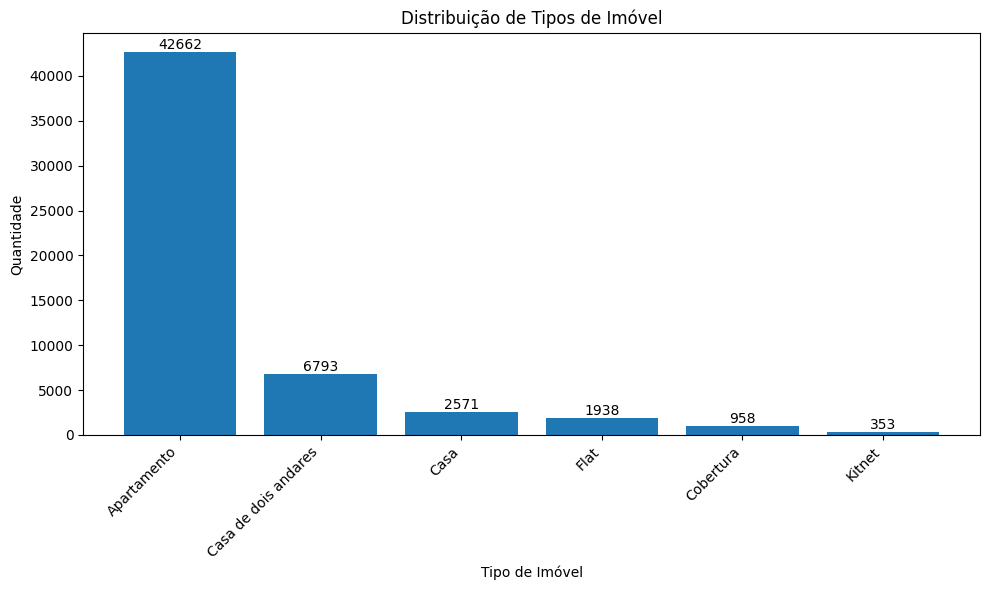

In [27]:
tipo_imovel_counts = df14['tipo_imovel'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(tipo_imovel_counts.index, tipo_imovel_counts.values)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.xlabel('Tipo de Imóvel')
plt.ylabel('Quantidade')
plt.title('Distribuição de Tipos de Imóvel')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [28]:
tipo_imovel_mapping = {
    'Flat': 'Apartamento',
    'Kitnet': 'Apartamento',
    'Cobertura': 'Apartamento',
    'Casa de dois andares': 'Casa',
}

df14['tipo_imovel'] = df14['tipo_imovel'].replace(tipo_imovel_mapping)

<ipython-input-28-c9e35f96d767>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df15['tipo_imovel'] = df15['tipo_imovel'].replace(tipo_imovel_mapping)


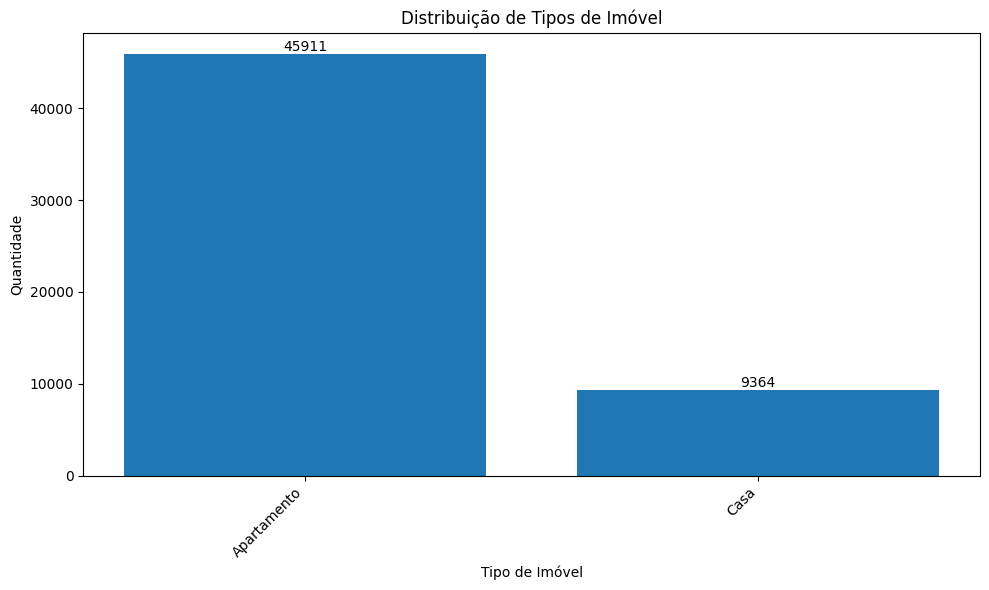

In [29]:
tipo_imovel_counts = df14['tipo_imovel'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(tipo_imovel_counts.index, tipo_imovel_counts.values)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.xlabel('Tipo de Imóvel')
plt.ylabel('Quantidade')
plt.title('Distribuição de Tipos de Imóvel')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Como a coluna de bairro é categórica (tipo de variável que não pode ser utilizada em modelos de regressão), será considerado o valor do m² por bairro

In [26]:
contagem_por_bairro = df14.groupby('bairro')['bairro'].count()
bairros_selecionados = contagem_por_bairro[contagem_por_bairro >= 5].index
df15 = df14[df14['bairro'].isin(bairros_selecionados)]

In [30]:
df15['valor_m2'] = df15['preco_venda'] / df15['area_util']

<ipython-input-30-b0e8133c6dfb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df15['valor_m2'] = df15['preco_venda'] / df15['area_util']


Como visto abaixo, os valores da média e mediana dos valores por baixo são muito próximos, a média é considerada um valor confiável.

In [31]:
df15.groupby('bairro')['valor_m2'].agg(['mean', 'median', 'min', 'max']).head(20)

,mean,median,min,max
bairro,,,,
Aclimação,5946.735427,5939.393939,2722.211111,10359.960000
Alto da Boa Vista,6499.801332,6635.416667,4331.250000,9691.379310
Alto da Lapa,6588.549506,6641.012821,2800.000000,11183.896552
Alto da Mooca,4794.358793,4732.718182,1724.245283,10128.787879
Alto de Pinheiros,6394.759804,6136.986301,2464.583333,11513.157895
Aricanduva,3355.225076,3266.666667,1774.992857,4669.211268
Artur Alvim,3051.029820,2979.142262,1680.000000,4757.271845
Barra Funda,5757.406356,5687.596364,3062.487500,10500.000000
Barro Branco,3564.608776,3322.033898,2898.437500,4873.417722


In [32]:
m2_bairro = df15.groupby('bairro')['valor_m2'].mean()

In [33]:
df15['preco_m2_bairro'] = df15['bairro'].map(m2_bairro)

<ipython-input-33-d9c0d27e1dbb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df15['preco_m2_bairro'] = df15['bairro'].map(m2_bairro)


Na variável de tipo imóvel, também categórica, será aplicado one-hot-encoder, visto que só a 2 categorias

In [34]:
df15 = pd.get_dummies(df15, columns=['tipo_imovel'], prefix='tipo_imovel', drop_first=True)

In [35]:
df16 = df15.copy()
df16['tipo_imovel_Casa'] = df16['tipo_imovel_Casa'].astype(int)

In [36]:
df17 = df16.drop(columns=['bairro', 'cidade', 'tipo_anuncio'])

In [37]:
df17.drop(columns=['valor_m2'], inplace=True)

In [38]:
df17.head()

,area_util,banheiros,suites,quartos,vagas_garagem,preco_venda,taxa_condominio,iptu_ano,preco_m2_bairro,tipo_imovel_Casa
3,80.0,2.0,1.0,3.0,2.0,739643,686.0,1610.0,9065.487165,0
6,94.0,1.0,0.0,3.0,2.0,630700,1120.0,489.0,8205.600216,0
9,141.0,4.0,3.0,4.0,2.0,1106000,0.0,0.0,5946.735427,0
12,32.0,1.0,0.0,1.0,1.0,118999,0.0,0.0,4790.768695,0
13,69.0,2.0,0.0,2.0,1.0,332500,339.0,819.0,4230.827316,0


Analisando a matriz de correlação vemos que os principais influenciadores do valor do imóvel são: area_util, banheiros, suites e preco_m2_bairro

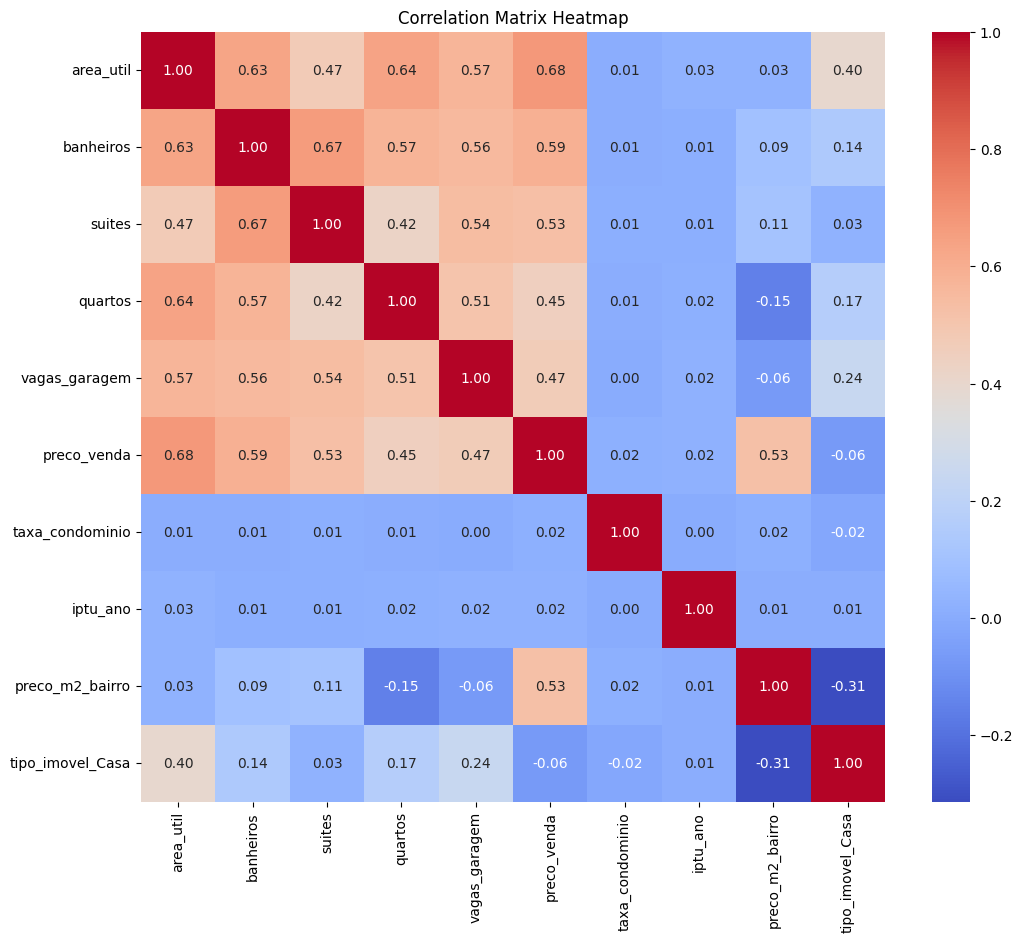

In [39]:
correlation_matrix = df17.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [40]:
X = df17.drop(columns=['preco_venda'])
y = df17['preco_venda']

O primeiro modelo a ser treinado será a regressão linear com regularização Lasso

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Foi aplicado o hiperparâmetro para achar o melhor valor do learning rate

In [43]:
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

print("Melhor alpha:", lasso_cv.alpha_)

Melhor alpha: 758.7018495299932


Analisando os coeficientes, as variáveis de maior influência são area_util (36%), preco_m2_bairro (29,7%) e tipo_imovel_Casa (12,1%), sendo tipo_imovel_Casa um coeficiente negativo, ou seja, um fator que quando verdadeiro, irá diminuir o valor do imóvel

In [44]:
coef_df = pd.Series(lasso_cv.coef_, index=X.columns)
print(coef_df[coef_df != 0])

area_util           160803.597672
banheiros            21837.770156
suites               29131.557304
quartos              19014.015431
vagas_garagem        30564.905130
taxa_condominio        185.456465
preco_m2_bairro     132891.841670
tipo_imovel_Casa    -54037.630360
dtype: float64


O modelo de regressão lasso apresentou um bom valor de R² (0,79), portanto o modelo explica relativamente bem o comportamento da amostra de treinamento, entretando o RMSE teve um valor consideravelmente alto em 135224 reais.

In [45]:
y_pred = lasso_cv.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE no teste:", rmse)

RMSE no teste: 135224.4646629005


In [46]:
r2 = r2_score(y_test, y_pred)
print("R²:", r2)

R²: 0.7899513720786939


Ao analisar os resíduos, vemos que embora grande parte de valores os resíduos ficam em torno de 0, para valores maiores há heterocedasticidade, o que explica o alto valor do RMSE

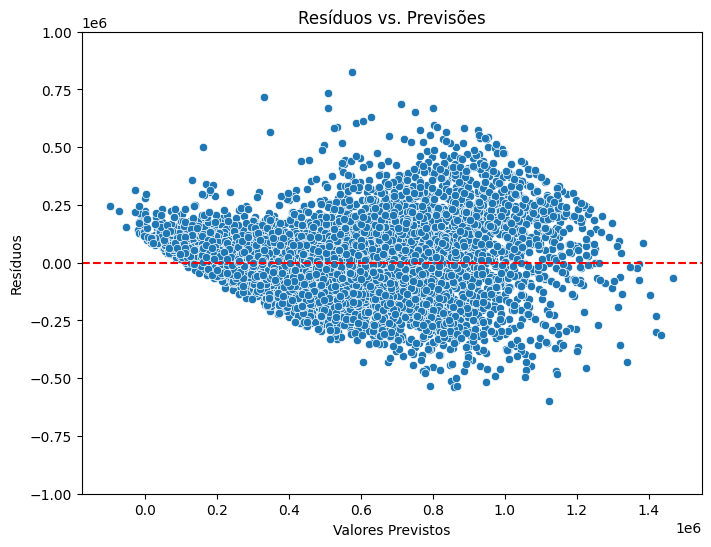

In [48]:
residuos = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Previsões')
plt.ylim(-1000000, 1000000)
plt.show()

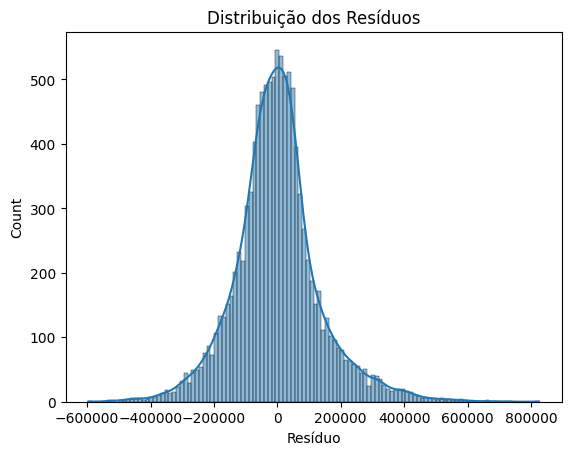

In [49]:
sns.histplot(residuos, kde=True)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo')
plt.show()

Como a heterocedasticidade é um fator contra as premissas da regressão linear, irei treinar um modelo de Random Forest, que defe lidar melhor com isso.

In [51]:
X = df17.drop(columns=['preco_venda'])
y = df17['preco_venda']

Para a Random Forest, houve aumento do R² para 0,89 o que indica que o modelo explica muito bem o comportamento da amostra de treinamento. Além disso, o RMSE caiu em 26%.

In [52]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = cross_val_score(rf, X, y, cv=kf, scoring=make_scorer(rmse))
r2_scores = cross_val_score(rf, X, y, cv=kf, scoring='r2')

print(f'RMSE: {rmse_scores.mean()} ± {rmse_scores.std()}')
print(f'R²: {r2_scores.mean()} ± {r2_scores.std()}')

RMSE: 99684.42572236885 ± 1394.3238174811463
R²: 0.8872380505469021 ± 0.003621327133288721


Embora o modelo tenha apresentado melhora no RMSE, é possível ver altos resíduos para valores mais altos, o que indica dificuldade do modelo para lidar com outliers.

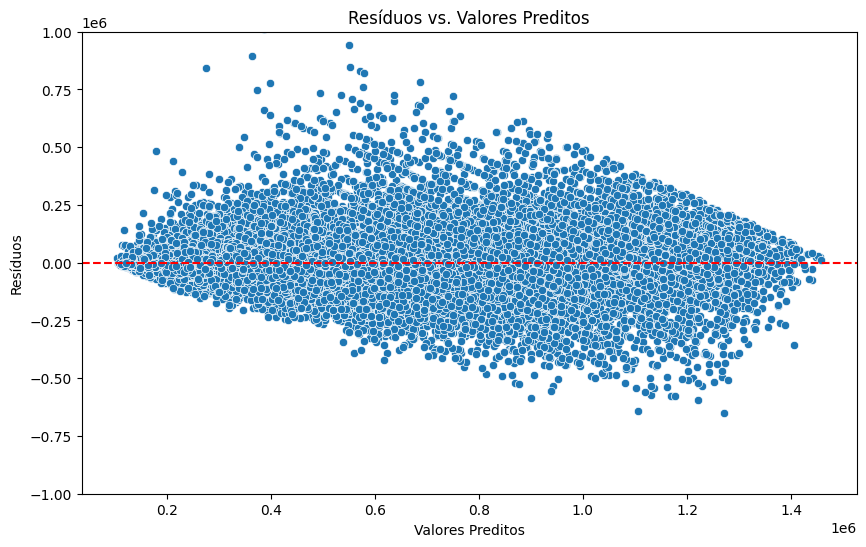

In [53]:
y_pred = cross_val_predict(rf, X, y, cv=kf)

residuos = y - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Valores Preditos')
plt.ylim(-1000000, 1000000)
plt.show()

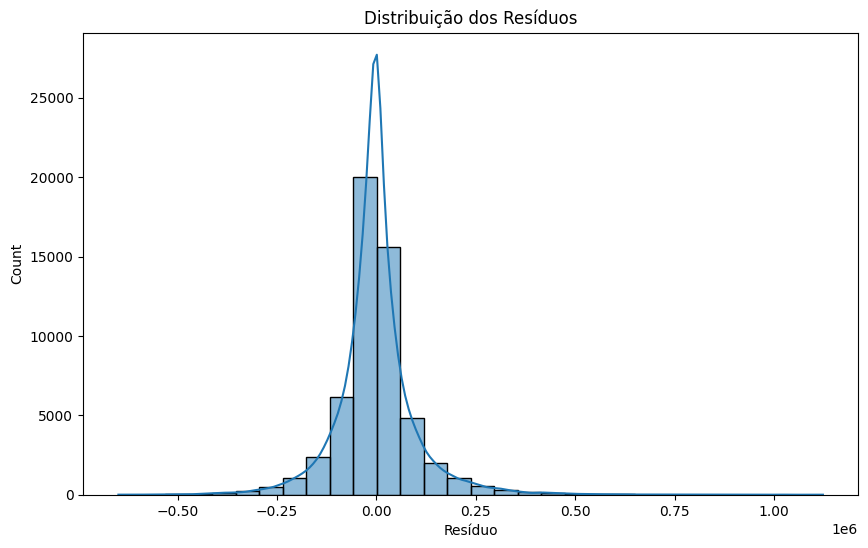

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(residuos, bins=30, kde=True)
plt.xlabel('Resíduo')
plt.title('Distribuição dos Resíduos')
plt.show()

Uma alternativa é filtrar imóveis com preços muito alto. Como no gráfico vemos um aumento dos valores de resíduos a partir de imóvei acima de 800k, irei definir este valor como máximo.

In [55]:
df18 = df17[df17['preco_venda'] <= 800000]

In [56]:
X = df18.drop(columns=['preco_venda'])
y = df18['preco_venda']

Com a retirada de registros acima de 800k, o modelo perdeu um pouco de explicabilidade, com R² em 84%, no entanto, o RMSE apresentou melhora de 34%.

In [57]:
rf_sep = RandomForestRegressor(n_estimators=100, random_state=42)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

kf2 = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = cross_val_score(rf_sep, X, y, cv=kf2, scoring=make_scorer(rmse))
r2_scores = cross_val_score(rf_sep, X, y, cv=kf2, scoring='r2')

print(f'RMSE: {rmse_scores.mean()} ± {rmse_scores.std()}')
print(f'R²: {r2_scores.mean()} ± {r2_scores.std()}')

RMSE: 65278.90557205826 ± 619.2744495845591
R²: 0.845637603803995 ± 0.0028040009439658543


O modelo apresentou melhora da distribuição de resíduos, embora para valores mais altos ainda tenha resíduos consideravelmente altos.

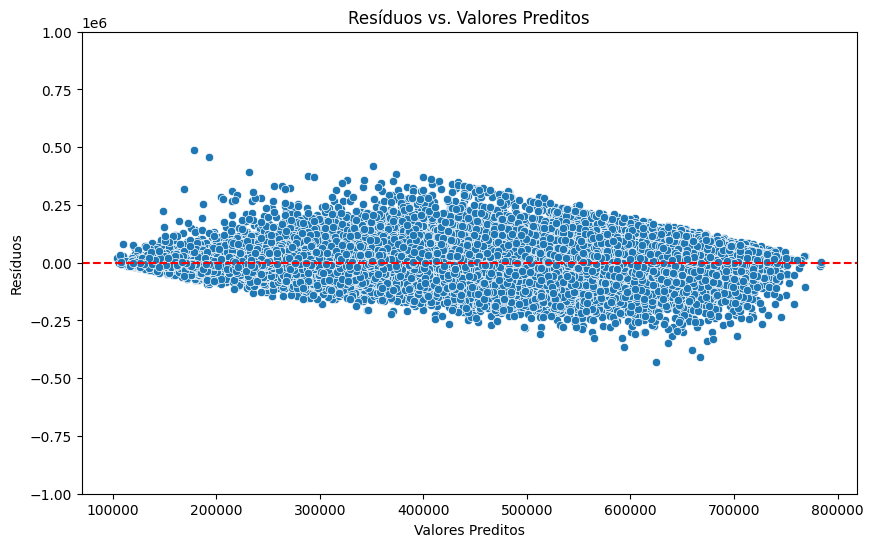

In [58]:
y_pred = cross_val_predict(rf_sep, X, y, cv=kf2)

residuos = y - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Valores Preditos')
plt.ylim(-1000000, 1000000)
plt.show()

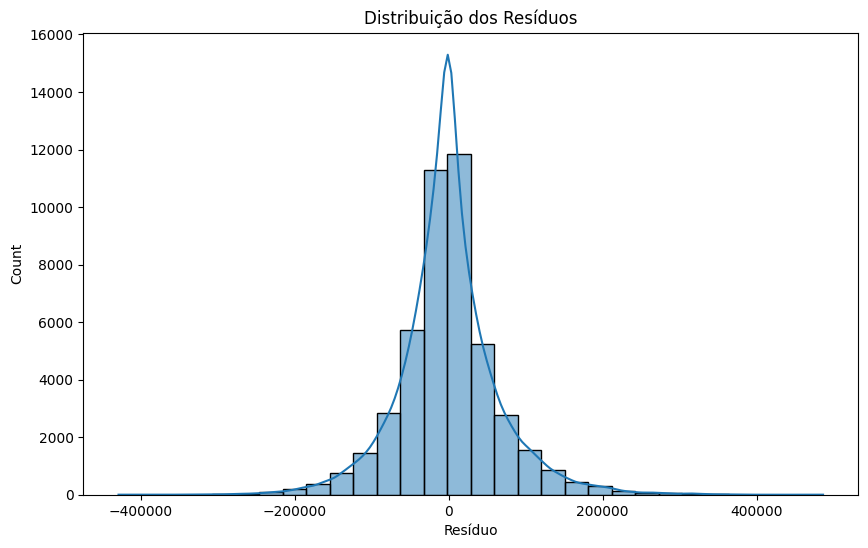

In [59]:
plt.figure(figsize=(10, 6))
sns.histplot(residuos, bins=30, kde=True)
plt.xlabel('Resíduo')
plt.title('Distribuição dos Resíduos')
plt.show()

# **Conclusão:**
* A Random Forest completa (0,88 R²) apresenta o melhor equilíbrio entre poder explicativo e erro de previsão.

* A versão limitada da RF tem menor erro absoluto, mas perde um pouco de sua explicabilidade.

* A regressão linear, embora interpretável, não captura adequadamente a complexidade dos dados imobiliários.

Possível melhoria seria desenvolver modelos específicos para cada faixa de preço, lidando melhor com imóveis de alto padrão, porém é necessário maior quantidade de registros para estes imóveis.